In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from rdkit.Chem import Descriptors
from sklearn.decomposition import PCA
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import RDConfig
from sklearn.preprocessing import StandardScaler
from syba.syba import SybaClassifier, SmiMolSupplier
from scscore.scscore.standalone_model_numpy import SCScorer
import os
import sys
import gzip
import glob
import time
import joblib
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer as sa

# Train and predict

In [7]:
df = pd.read_csv('data/7Mtrain_descriptors.csv')

In [212]:
print(len(df))
df.head(3)

21537


,smiles,steps,syba,sa,sc,mol,MolWt,MolLogP,NumHAccept,NumHDonors,NumHetero,TPSA,steps_bins,less_steps_bins
0,Cc1ncc(COP(=O)(O)O)c(C=O)c1O,1,23.635963,2.979265,2.881520,<rdkit.Chem.rdchem.Mol object at 0x0000015A69A...,247.143,0.51742,5,3,8,116.95,0,0
1,CC(=O)C(=O)O,1,2.978129,1.841613,1.361031,<rdkit.Chem.rdchem.Mol object at 0x0000015A69A...,88.062,-0.34000,2,1,3,54.37,0,0
2,C[N+](C)(C)CCO,1,20.562749,3.003778,1.000185,<rdkit.Chem.rdchem.Mol object at 0x0000015A69A...,104.173,-0.31510,1,1,2,20.23,0,0


## Divide into bins

In [8]:
df['steps_bins'] = pd.cut(df['steps'], [0,1,3,6,10,13], labels=False) #, labels=False
df.steps_bins.value_counts()
# (0, 1] - 0, (1, 3] - 1, (3, 6] - 2, (6, 10]- 3, (10, 13] - 4

3    6847
4    4946
2    4040
1    3616
0    2088
Name: steps_bins, dtype: int64

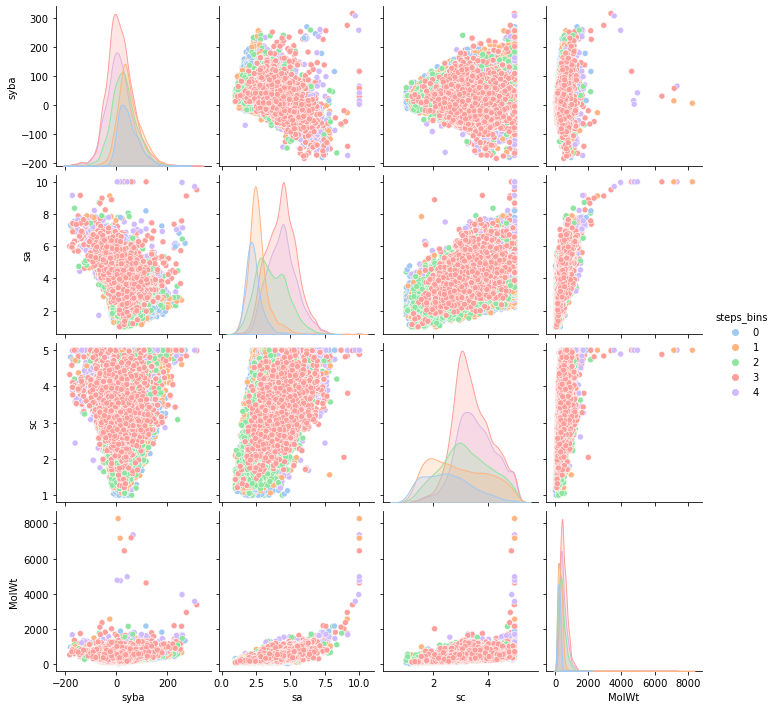

In [5]:
sns.pairplot(df[['steps_bins', 'syba', 'sa', 'sc','MolWt']], hue='steps_bins', palette = 'pastel')

In [11]:
# less bins
df['less_steps_bins'] = pd.cut(df['steps'], [0,2,5,10], labels=[0,1,2]) #, labels=False
df.less_steps_bins.value_counts()

2    8623
1    4484
0    3484
Name: less_steps_bins, dtype: int64

In [12]:
df_less = df.dropna()

# PCA

In [214]:
pca = PCA()
df2 = df[['syba', 'sa', 'sc','MolWt','MolLogP','NumHAccept','NumHDonors','NumHetero','TPSA']] 
scaled_df_2 = StandardScaler().fit_transform(df2) 
pca_fit = pca.fit(scaled_df_2)

In [136]:
#pca.explained_variance_ratio_ 
np.cumsum(pca.explained_variance_ratio_)

array([0.51638168, 0.72096092, 0.85730698, 0.94096622, 0.96881299,
       0.98962734, 0.99468296, 0.99771033, 1.        ])

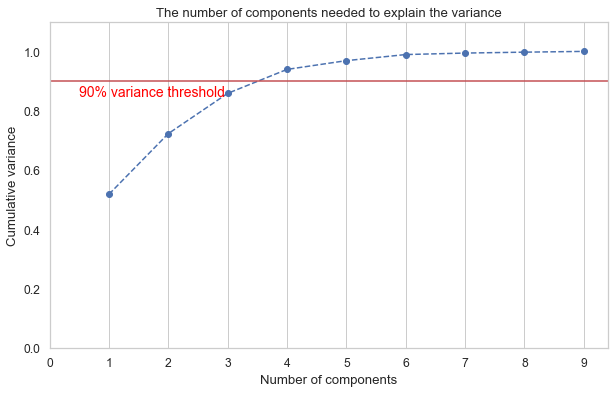

In [147]:
plt.rcParams["figure.figsize"] = (10,6)
fig, ax = plt.subplots()
xi = np.arange(1, len(pca_fit.components_)+1, step=1)
y = np.cumsum(pca_fit.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of components')
plt.xticks(np.arange(0, len(pca_fit.components_)+1, step=1))
plt.ylabel('Cumulative variance')
plt.title('The number of components needed to explain the variance')

plt.axhline(y=0.90, color='r', linestyle='-')
plt.text(0.5, 0.85, '90% variance threshold', color = 'red', fontsize=14)
sns.set(font_scale=1.1)
sns.set_style("whitegrid", {'axes.grid' : False})
ax.grid(axis='x')
plt.show()

In [237]:
def myplot(score, coeff, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    scatter =plt.scatter(xs * scalex, ys * scaley, c = df.steps_bins) 
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'blue', alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'red', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'red', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.legend(handles=scatter.legend_elements()[0], labels=['0','1','2','3','4'])
    plt.grid()

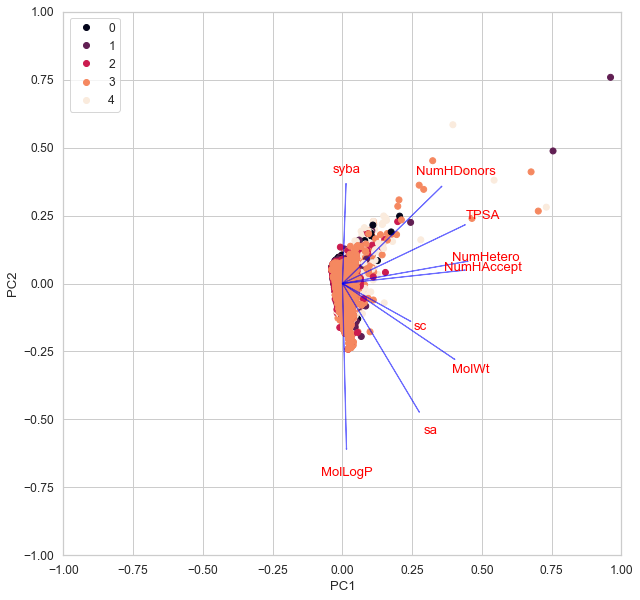

In [238]:
plt.rcParams["figure.figsize"] = (10,10)
pca = PCA(n_components =2)
pca.fit_transform(scaled_df_2)
pca_scores = PCA().fit_transform(scaled_df_2) 
myplot(pca_scores[:,0:2], np.transpose(pca.components_[0:2, :]),
       ('syba', 'sa', 'sc','MolWt','MolLogP','NumHAccept','NumHDonors','NumHetero','TPSA'))
plt.show()

In [127]:
pca_df = pd.DataFrame(data = scaled_df_2, 
                      columns = [f"PC {i}" for i in range(1,len(df2.columns)+1)])

shape:  (21537, 9)


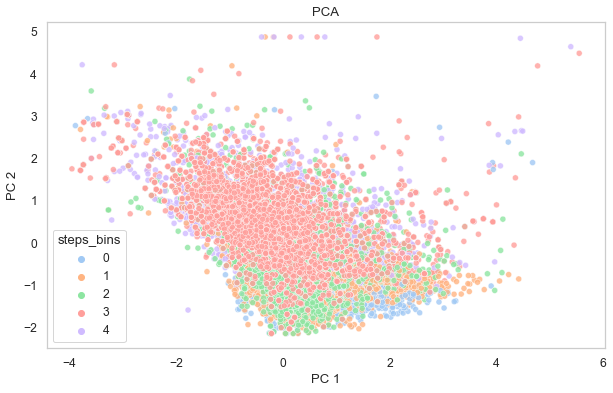

In [148]:
plot = sns.scatterplot(data=pca_df, x="PC 1", y="PC 2", hue=df.steps_bins,
                       alpha=0.8, palette = 'pastel').set_title('PCA')
print('shape: ', scaled_df_2.shape)

### Less bins

In [138]:
df2_less = df_less[['syba', 'sa', 'sc','MolWt','MolLogP','NumHAccept','NumHDonors','NumHetero','TPSA']] 
scaled_df_2_less = StandardScaler().fit_transform(df2_less) 
pca_fit_less = pca.fit(scaled_df_2_less)

In [139]:
pca_df_less = pd.DataFrame(data = scaled_df_2_less, columns = [f"PC {i}" for i in range(1,len(df2.columns)+1)])

shape:  (16591, 9)


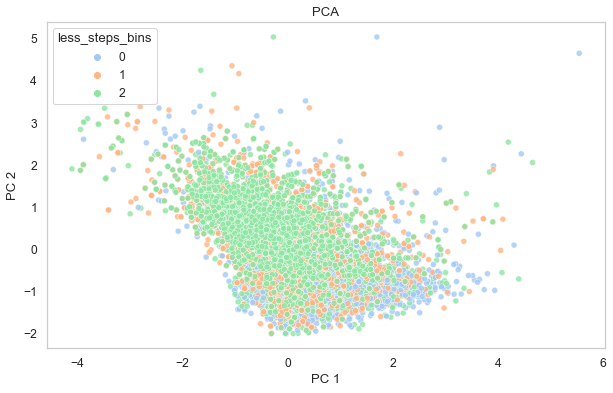

In [149]:
plot = sns.scatterplot(data=pca_df_less, x="PC 1", y="PC 2", hue=df.less_steps_bins,
                       alpha=0.8, palette = 'pastel').set_title('PCA')
print('shape: ', scaled_df_2_less.shape)

# Models

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [162]:
LR = LogisticRegression(random_state=0, max_iter=10000)
RFC = RandomForestClassifier(random_state=0)
MLP = MLPClassifier(random_state=1, max_iter=2000)
SV = SVR()
KNR = KNeighborsRegressor()
RIDGE = Ridge(random_state=1)
RFR = RandomForestRegressor(random_state=0)

models = [LR,RFC,MLP,SV,KNR,RIDGE,RFR]
score = ['balanced_accuracy', 'balanced_accuracy','balanced_accuracy',
         'neg_mean_squared_error','neg_mean_squared_error',
         'neg_mean_squared_error','neg_mean_squared_error']
names = ['LR','RFC','MLP','SVR','KNR','RIDGE','RFR']
score_name = 3*['balanced_acc'] + 4*['MSE']

col = ['syba', 'sa', 'sc','MolWt']
col3 = ['syba', 'sa', 'sc','MolWt','MolLogP','NumHAccept','NumHDonors','NumHetero','TPSA']
y = np.array(df.steps_bins)
y_less_bins = np.array(df_less.less_steps_bins)

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

In [150]:
def calculate_score(models, x, y, names, score, score_name):
    i = 0
    errors = []
    for model in models:
        cross = cross_val_score(model, x, y, scoring=score[i], cv=5)
        print(names[i], score_name[i], end = ': ')
        i = i+1
        print(" %0.3f (+/- %0.3f)" % (cross.mean(), cross.std()))
        errors.append(cross)
    return errors

In [52]:
def cross_scoring_reg(model, X, Y):
    score = {'r2':'r2',
         'MAE':'neg_mean_absolute_error',
         'MSE':'neg_mean_squared_error',
         'RMSE':'neg_root_mean_squared_error'}
    scores = cross_validate(model, X, Y, scoring=score, cv=cv, n_jobs=-1)
    return scores

def calculate_score_reg(models, x, y, names):
    i = 0
    for model in models:
        score = cross_scoring_reg(model, x, y)
        print(names[i])
        i = i+1
        print(" %0.3f (+/- %0.3f)" % (score['test_R2'].mean(), score['test_R2'].std()))
        print(" %0.3f (+/- %0.3f)" % (score['test_MAE'].mean(), score['test_MAE'].std()))
        print(" %0.3f (+/- %0.3f)" % (score['test_MSE'].mean(), score['test_MSE'].std()))
        print(" %0.3f (+/- %0.3f)" % (score['test_RMSE'].mean(), score['test_RMSE'].std()))

### Score

In [154]:
er1 = calculate_score(models, np.array(df[['syba', 'sa', 'sc']]), y, names, score, score_name)

LR balanced_acc:  0.317 (+/- 0.020)
RFC balanced_acc:  0.378 (+/- 0.023)
MLP balanced_acc:  0.339 (+/- 0.018)
SVR MSE:  -1.147 (+/- 0.423)
KNR MSE:  -1.125 (+/- 0.394)
RIDGE MSE:  -1.141 (+/- 0.498)
RFR MSE:  -1.009 (+/- 0.374)


In [59]:
er1_less = calculate_score(models, np.array(df_less[['syba', 'sa', 'sc']]), y_less_bins, names, score, score_name)

LR balanced_acc:  0.552 (+/- 0.061)
RFC balanced_acc:  0.592 (+/- 0.082)
MLP balanced_acc:  0.546 (+/- 0.061)
SVR MSE:  -0.519 (+/- 0.277)
KNR MSE:  -0.472 (+/- 0.229)
RIDGE MSE:  -0.495 (+/- 0.219)
RFR MSE:  -0.397 (+/- 0.215)


### Score and MolWt

In [155]:
er2 = calculate_score(models, np.array(df[col]), y, names, score, score_name)

LR balanced_acc:  0.339 (+/- 0.016)
RFC balanced_acc:  0.401 (+/- 0.030)
MLP balanced_acc:  0.340 (+/- 0.020)
SVR MSE:  -1.073 (+/- 0.367)
KNR MSE:  -1.179 (+/- 0.456)
RIDGE MSE:  -1.142 (+/- 0.486)
RFR MSE:  -0.965 (+/- 0.342)


In [156]:
er2_less = calculate_score(models, np.array(df_less[col]), y_less_bins, names, score, score_name)

LR balanced_acc:  0.562 (+/- 0.063)
RFC balanced_acc:  0.605 (+/- 0.086)
MLP balanced_acc:  0.524 (+/- 0.066)
SVR MSE:  -0.484 (+/- 0.238)
KNR MSE:  -0.475 (+/- 0.229)
RIDGE MSE:  -0.498 (+/- 0.221)
RFR MSE:  -0.373 (+/- 0.201)


### Score and all descriptors  

In [157]:
er3 = calculate_score(models, np.array(df[col3]), y, names, score, score_name)

LR balanced_acc:  0.369 (+/- 0.032)
RFC balanced_acc:  0.431 (+/- 0.025)
MLP balanced_acc:  0.354 (+/- 0.026)
SVR MSE:  -1.048 (+/- 0.364)
KNR MSE:  -1.150 (+/- 0.433)
RIDGE MSE:  -1.153 (+/- 0.492)
RFR MSE:  -0.916 (+/- 0.317)


In [158]:
er3_less = calculate_score(models, np.array(df_less[col3]), y_less_bins, names, score, score_name)

LR balanced_acc:  0.581 (+/- 0.072)
RFC balanced_acc:  0.639 (+/- 0.098)
MLP balanced_acc:  0.556 (+/- 0.061)
SVR MSE:  -0.476 (+/- 0.234)
KNR MSE:  -0.469 (+/- 0.225)
RIDGE MSE:  -0.474 (+/- 0.212)
RFR MSE:  -0.355 (+/- 0.193)


### PCA components
- computet from all descriptors and scores
- used 5 the most important components

In [159]:
er4 = calculate_score(models, np.array(pca_df[['PC 1','PC 2','PC 3','PC 4','PC 5']]), y, names, score, score_name)

LR balanced_acc:  0.364 (+/- 0.030)
RFC balanced_acc:  0.418 (+/- 0.020)
MLP balanced_acc:  0.412 (+/- 0.030)
SVR MSE:  -0.961 (+/- 0.249)
KNR MSE:  -1.043 (+/- 0.340)
RIDGE MSE:  -1.155 (+/- 0.487)
RFR MSE:  -0.938 (+/- 0.330)


In [160]:
er4_less = calculate_score(models, np.array(pca_df_less[['PC 1','PC 2','PC 3','PC 4','PC 5']]),
                           y_less_bins, names, score, score_name)

LR balanced_acc:  0.569 (+/- 0.065)
RFC balanced_acc:  0.621 (+/- 0.087)
MLP balanced_acc:  0.612 (+/- 0.085)
SVR MSE:  -0.427 (+/- 0.224)
KNR MSE:  -0.425 (+/- 0.217)
RIDGE MSE:  -0.483 (+/- 0.215)
RFR MSE:  -0.363 (+/- 0.197)


### Visualization

In [175]:
dfs =[]
xs = ['score','score+MolWT','score+descriptors','pca']
er = [er1, er2, er3, er4]
for k in range(len(xs)):
    for i in range(len(names)):
        data = {'model' : names[i],
                'x': xs[k], 
                'score': abs(er[k][i])}
        d = pd.DataFrame(data=data)
        dfs.append(d)
df_all = pd.concat(dfs, axis=0, ignore_index=True)
df_all['categories'] = 'regression'
df_all.loc[df_all['model'] == 'LR', 'categories'] = 'classification'
df_all.loc[df_all['model'] == 'RFC', 'categories'] = 'classification'
df_all.loc[df_all['model'] == 'MLP', 'categories'] = 'classification'
df_all.head()

,model,x,score,categories
0,LR,score,0.298946,classification
1,LR,score,0.338899,classification
2,LR,score,0.340829,classification
3,LR,score,0.309840,classification
4,LR,score,0.294778,classification


In [209]:
filepath = Path('data/df_all_models_scores.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_all.to_csv(filepath, index=False) 

Text(0, 0.5, 'Balanced accuracy')

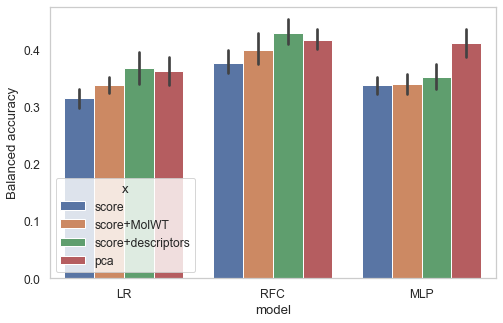

In [208]:
plt.figure(figsize=(8,5))
ax = sns.barplot(x='model', y='score', hue='x', data=df_all.loc[df_all['categories'] == 'classification'])
ax.set_ylabel('Balanced accuracy')

Text(0, 0.5, 'MSE')

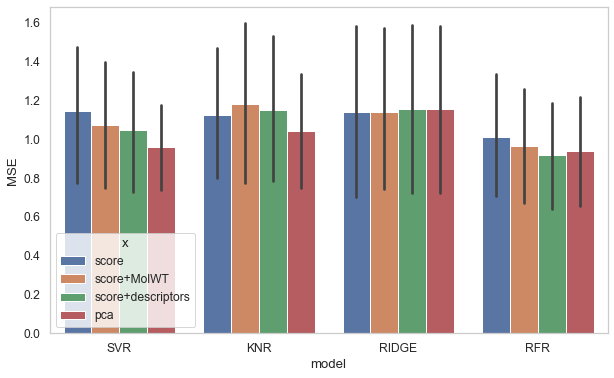

In [205]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x='model', y='score', hue='x', data=df_all.loc[df_all['categories'] == 'regression'])
#plt.ylim(0.5, 1.7)
ax.set_ylabel('MSE')

In [192]:
dfs =[]
er_less = [er1_less, er2_less, er3_less, er4_less]
for k in range(len(xs)):
    for i in range(len(names)):
        data = {'model' : names[i],'x': xs[k], 'score': abs(er_less[k][i]), 'categories': 'regression'}
        d = pd.DataFrame(data=data)
        dfs.append(d)
df_all_less = pd.concat(dfs, axis=0, ignore_index=True)
df_all_less.loc[df_all_less['model'] == 'LR', 'categories'] = 'classification'
df_all_less.loc[df_all_less['model'] == 'RFC', 'categories'] = 'classification'
df_all_less.loc[df_all_less['model'] == 'MLP', 'categories'] = 'classification'
df_all_less.head()

,model,x,score,categories
0,LR,score,0.438862,classification
1,LR,score,0.553611,classification
2,LR,score,0.616790,classification
3,LR,score,0.589606,classification
4,LR,score,0.560754,classification


Text(0, 0.5, 'Balanced accuracy')

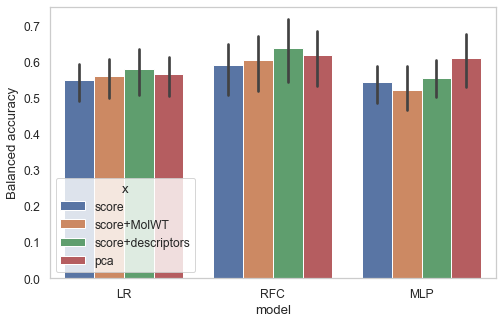

In [207]:
plt.figure(figsize=(8,5))
ax = sns.barplot(x='model', y='score', hue='x', data=df_all_less.loc[df_all_less['categories'] == 'classification'])
ax.set_ylabel('Balanced accuracy')

Text(0, 0.5, 'MSE')

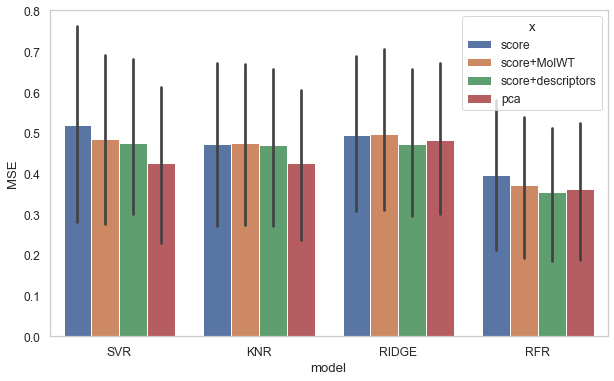

In [204]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x='model', y='score', hue='x', data=df_all_less.loc[df_all_less['categories'] == 'regression'])
ax.set_ylabel('MSE')

In [210]:
filepath = Path('data/df_all_less_models_scores.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_all_less.to_csv(filepath, index=False) 

In [102]:
filepath = Path('data/trfada_train_data.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True) 
sample = df.sample(n=15000)
sample[['smiles','steps_bins']].to_csv(filepath, index=False) 

In [20]:
trfada_test_clas = pd.read_csv('data/trfada/trfada_test_res_trainig.csv')
trfada_test_clas.head()

,f1,mcc
0,0.494397,0.351528


In [ ]:
trfada_test_reg = pd.read_csv('data/trfada_test_res_reg.csv')
trfada_test_reg.head()

### Hyperparametric optimization 

In [16]:
#RFR
start = time.time()
params = { 'max_depth': [8, 15, 20, 30, None],
           'max_features': ['auto', 'sqrt'],
           'n_estimators': [50, 100, 200]}
search = GridSearchCV(RFR, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)
results_RFR = search.fit(df[col], y)
print('Best MSE: %0.3f' % -results_RFR.best_score_)
print('Best Hyperparameters: %s' % results_RFR.best_params_)
print("%0.3f min"%((time.time()-start)/60))

Best MSE: 0.791
Best Hyperparameters: {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 200}
92.857 min


In [57]:
#RFR
# all descriptors
start = time.time()
params = { 'max_depth': [8, 15, 20, 30, None],
           'max_features': ['auto', 'sqrt'],
           'n_estimators': [50, 100, 200]}
search = GridSearchCV(RFR, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)
results_RFR = search.fit(df[col3], y)
print('Best MSE: %0.3f' % -results_RFR.best_score_)
print('Best Hyperparameters: %s' % results_RFR.best_params_)
print("%0.3f min"%((time.time()-start)/60))

Best MSE: 0.737
Best Hyperparameters: {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 200}
77.769 min


In [17]:
#RFR
# less bins
start = time.time()
params = { 'max_depth': [8, 15, 20, 30, None],
           'max_features': ['auto', 'sqrt'],
           'n_estimators': [50, 100, 200]}
search = GridSearchCV(RFR, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)
results_RFR = search.fit(df_less[col], y_less_bins)
print('Best MSE: %0.3f' % -results_RFR.best_score_)
print('Best Hyperparameters: %s' % results_RFR.best_params_)
print("%0.3f min"%((time.time()-start)/60))

Best MSE: 0.278
Best Hyperparameters: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 200}
37.525 min


## Feature importances

- https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

### *Scores and MolWt*

In [248]:
x = df[col]
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1, test_size=0.25)

In [249]:
RFR = RandomForestRegressor(random_state=0, max_depth=15, max_features='sqrt', n_estimators=200)
RFR.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=200,
                      random_state=0)

In [250]:
importances = RFR.feature_importances_
std = np.std([tree.feature_importances_ for tree in RFR.estimators_], axis=0)
forest_importances = pd.Series(importances, index=col)

In [251]:
forest_importances = forest_importances.sort_values(ascending=False)

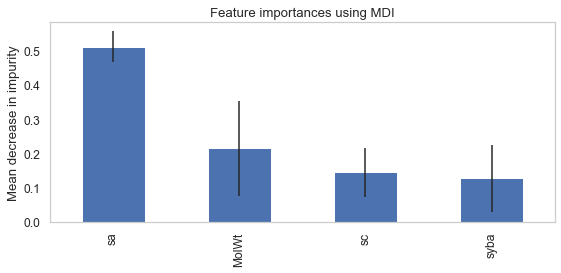

In [254]:
fig, ax = plt.subplots(figsize=(8,4))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI") #Feature importance based on mean decrease in impurity
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [255]:
result = permutation_importance(RFR, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=col)
forest_importances = forest_importances.sort_values(ascending=False)

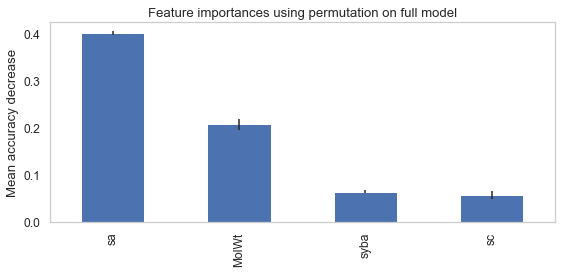

In [257]:
fig, ax = plt.subplots(figsize=(8,4))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### *All descriptors*

In [40]:
x2 = df[col3]

In [41]:
RFR = RandomForestRegressor(random_state=0, max_depth=15, max_features='sqrt', n_estimators=200)
RFR.fit(x2, y)

RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=200,
                      random_state=0)

In [43]:
importances = RFR.feature_importances_
std = np.std([tree.feature_importances_ for tree in RFR.estimators_], axis=0)
forest_importances = pd.Series(importances, index=col3)
forest_importances = forest_importances.sort_values(ascending=False)

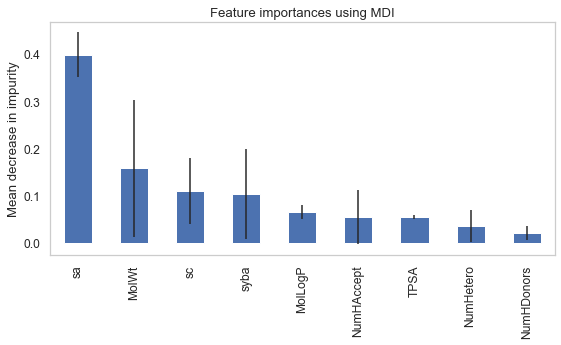

In [247]:
fig, ax = plt.subplots(figsize=(8, 5))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI") #Feature importance based on mean decrease in impurity
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# My data

In [37]:
df_my = pd.read_csv('data/7Mfiltered.csv')
print(len(df_my))
df_my.head()

997467


,index,ID,Smiles,pipeline
0,4389652,NaN,C[C@@H](CCc1ccccc1)CC(=O)N1CCC(c2n[nH]c(=S)n2C...,2
1,6393140,CHEMBL3545584,Nc1nc(-c2ccc(NC(=O)c3ccc(C(F)(F)F)cc3)cc2)c[nH]1,0
2,6514964,NaN,O=C(CN1C[C@@H]2CC(=O)Nc3cccc1c32)Nc1ccc2c(c1)C...,2
3,5863258,NaN,Cc1nnc(CN(C)[C@@H]2CCN(C(=O)c3n[nH]c(C)c3O)C2)o1,2
4,6147679,NaN,N#Cc1ccc([N+](=O)[O-])c(N[C@H]2CC[C@@H](O)C2)c1,2


### Score

In [14]:
sc = SCScorer()
sc.restore(os.path.join(r'C:\Users\domiz\Documents\Python\DP\scscore',
                             'models', 
                             'full_reaxys_model_1024bool', 
                             'model.ckpt-10654.as_numpy.json.gz'))
#('/home/zumrovad/DP/scscore', 'models', 'full_reaxys_model_1024bool', 'model.ckpt-10654.as_numpy.json.gz'))
sy = SybaClassifier()
sy.fitDefaultScore()

Restored variables from C:\Users\domiz\Documents\Python\DP\scscore\models\full_reaxys_model_1024bool\model.ckpt-10654.as_numpy.json.gz


In [28]:
syba = [sy.predict(smile) for smile in df_my.Smiles]
df_my = df_my.assign(syba=syba)

In [29]:
sascore = [sa.calculateScore(Chem.MolFromSmiles(smile)) for smile in df_my.Smiles]
df_my = df_my.assign(sascore=sascore)

In [30]:
scscore = [sc.get_score_from_smi(smile)[1] for smile in df_my.Smiles]
df_my = df_my.assign(scscore=scscore)

In [31]:
df_my.head()

,index,ID,Smiles,pipeline,syba,sascore,scscore
0,4389652,NaN,C[C@@H](CCc1ccccc1)CC(=O)N1CCC(c2n[nH]c(=S)n2C...,2,119.960343,2.894259,4.237269
1,6393140,CHEMBL3545584,Nc1nc(-c2ccc(NC(=O)c3ccc(C(F)(F)F)cc3)cc2)c[nH]1,0,129.484249,2.288141,3.923137
2,6514964,NaN,O=C(CN1C[C@@H]2CC(=O)Nc3cccc1c32)Nc1ccc2c(c1)C...,2,7.593369,4.121595,4.974018
3,5863258,NaN,Cc1nnc(CN(C)[C@@H]2CCN(C(=O)c3n[nH]c(C)c3O)C2)o1,2,60.853670,3.395065,4.658135
4,6147679,NaN,N#Cc1ccc([N+](=O)[O-])c(N[C@H]2CC[C@@H](O)C2)c1,2,43.985205,3.108077,2.646577


In [32]:
filepath = Path('data/7Mscores.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_my.to_csv(filepath, index=False) 

# Predict 

In [272]:
df_my = pd.read_csv('data/7Mscores.csv')

In [274]:
mols = [Chem.MolFromSmiles(m) for m in df_my.Smiles]
df_my = df_my.assign(mol=mols)
df_my['MolWt'] = df_my.mol.apply(Descriptors.MolWt)

In [275]:
df_my['MolLogP'] = df_my.mol.apply(Descriptors.MolLogP)
df_my['NumHAccept'] = df_my.mol.apply(Descriptors.NumHAcceptors)
df_my['NumHDonors'] = df_my.mol.apply(Descriptors.NumHDonors)
df_my['NumHetero'] = df_my.mol.apply(Descriptors.NumHeteroatoms)
df_my['TPSA'] = df_my.mol.apply(Descriptors.TPSA)

Text(0.5, 1.0, 'sascore')

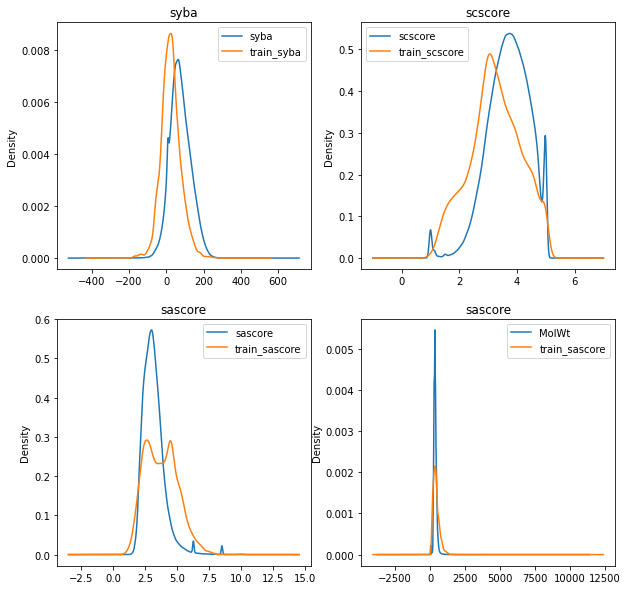

In [42]:
# My data vs. train data
fig, axs = plt.subplots(ncols=2, nrows=2,figsize=(10,10))
plt.subplots_adjust(wspace = 0.2)

df_my[['syba']].assign(train_syba=df[['syba']]).plot.density(ax=axs[0,0]).set_title('syba')
df_my[['scscore']].assign(train_scscore=df[['sc']]).plot.density(ax=axs[0,1]).set_title('scscore')
df_my[['sascore']].assign(train_sascore=df[['sa']]).plot.density(ax=axs[1,0]).set_title('sascore')
df_my[['MolWt']].assign(train_sascore=df[['MolWt']]).plot.density(ax=axs[1,1]).set_title('sascore')

In [280]:
pca = PCA()
df2_my = df_my[['syba', 'sascore', 'scscore','MolWt','MolLogP','NumHAccept','NumHDonors','NumHetero','TPSA']]
scaled_df2_my = StandardScaler().fit_transform(df2_my) 
pca_fit_my = pca.fit(scaled_df2_my)
pca_df_my = pd.DataFrame(data = scaled_df2_my, columns = [f"PC {i}" for i in range(1,len(df2.columns)+1)])

In [282]:
pca_df_my.head(3)

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9
0,0.821526,-0.295031,0.736461,0.115222,0.687586,-0.253243,-0.513363,-0.225824,-0.523915
1,0.994217,-1.012337,0.302545,-0.112716,0.741690,-0.692859,1.087973,0.435746,0.224588
2,-1.215954,1.157451,1.754143,0.923294,0.137373,0.186374,1.087973,0.435746,0.716324


In [284]:
np.cumsum(pca.explained_variance_ratio_)

array([0.45581929, 0.66354036, 0.7882918 , 0.86617617, 0.92738284,
       0.96838014, 0.9847905 , 0.99245471, 1.        ])

In [301]:
y = np.array(df.steps_bins)
#x = np.array(df[['syba', 'sa', 'sc','MolWt']])
x = np.array(pca_df[['PC 1','PC 2','PC 3','PC 4','PC 5']])
#X = np.array(df_my[['syba', 'sascore', 'scscore','MolWt']])
X = np.array(pca_df_my[['PC 1','PC 2','PC 3','PC 4','PC 5']])

In [286]:
RFR = RandomForestRegressor(random_state=0, max_depth=15, max_features='sqrt', n_estimators=200)

In [302]:
RFR_fit = RFR.fit(x, y)
predict = RFR_fit.predict(X)

<AxesSubplot:ylabel='Count'>

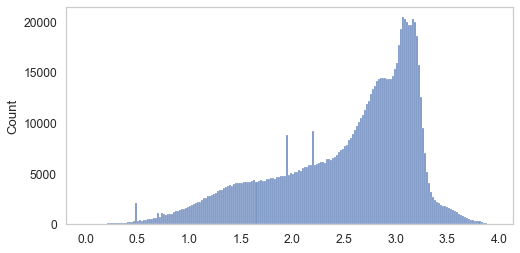

In [303]:
plt.figure(figsize=(8,4))
sns.histplot(predict)

In [304]:
df_my = df_my.assign(predict=[round(y) for y in predict])

In [305]:
df_my.predict.value_counts()
#(0, 1] - 0, (1, 3] - 1, (3, 6] - 2, (6, 10]- 3, (10, 13] - 4

3    597274
2    278833
1    101693
4     15003
0      4664
Name: predict, dtype: int64

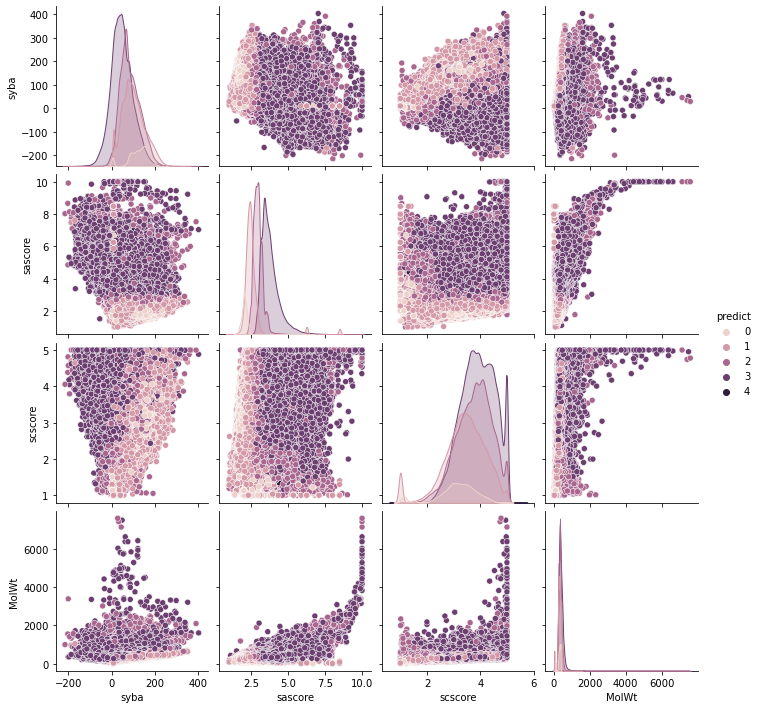

In [50]:
sns.pairplot(df_my[['predict','syba', 'sascore', 'scscore','MolWt']], hue='predict')

In [306]:
filepath = Path('data/7Mpredict.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_my.to_csv(filepath, index=False) 

### Feature importances

In [266]:
df_my = pd.read_csv('data/7Mpredict.csv')

In [307]:
#X = np.array(df_my[['syba', 'sascore', 'scscore','MolWt']])
Y = np.array(df_my.predict)
RFR = RandomForestRegressor(random_state=0, max_depth=15, max_features='sqrt', n_estimators=200)
RFR_fit = RFR.fit(X, Y)

In [309]:
importances = RFR.feature_importances_
std = np.std([tree.feature_importances_ for tree in RFR.estimators_], axis=0)
forest_importances = pd.Series(importances, index=['PC 1','PC 2','PC 3','PC 4','PC 5'])
forest_importances = forest_importances.sort_values(ascending=False)

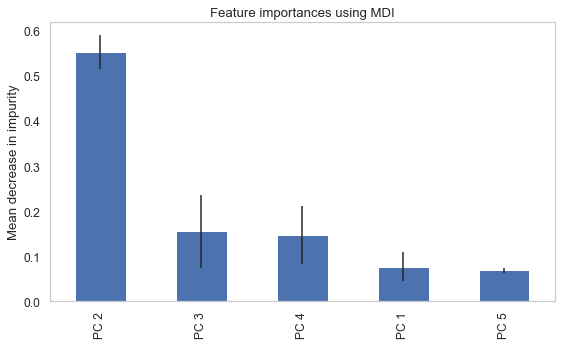

In [310]:
fig, ax = plt.subplots(figsize=(8, 5))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI") #Feature importance based on mean decrease in impurity
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

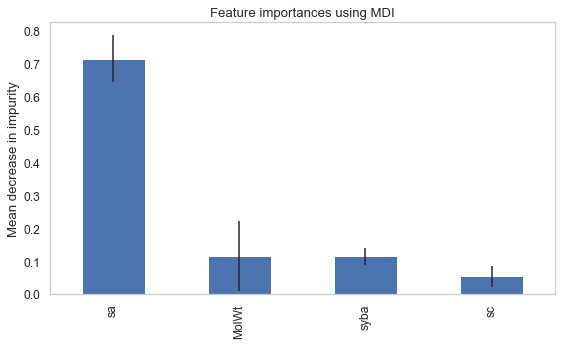

In [271]:
# old version with scores and molWt
fig, ax = plt.subplots(figsize=(8, 5))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI") #Feature importance based on mean decrease in impurity
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [311]:
for i in range(5):
    df_cut = df_my[df_my.predict == i]
    sample = df_cut.sample(n=200)
    sample.Smiles.to_csv('data/7Msmiles200-'+str(i)+'.txt', header=None, index=None, sep=' ', mode='a')

### Prediction on the first 1 000 000

In [15]:
df_predict0 = pd.read_csv('data/7Mpredict0.csv')
df_predict0.predict.value_counts()

3    502627
2    271099
1    190204
0     32286
4       274
Name: predict, dtype: int64

In [18]:
df_4 = df_predict0[df_predict0.predict == 4]

In [22]:
mols = [Chem.MolFromSmiles(m) for m in df_4.Smiles]
df_4 = df_4.assign(mol=mols)

In [26]:
df_4.head()

,ID,Smiles,pipeline,syba,sascore,scscore,mol,MolWt,predict
11679,CHEMBL1429573,C#CC1(O)C=CC2C3CCC4=CC(=O)CCC4C3CCC21CC,2,-76.936338,4.951782,3.102499,<rdkit.Chem.rdchem.Mol object at 0x0000026294F...,310.437,4
11692,CHEMBL1894852,C#CC1(O)CCC2C3CCC4=CC(=O)CCC4=C3C=CC21C,2,-77.037748,4.636489,3.299971,<rdkit.Chem.rdchem.Mol object at 0x00000262795...,294.394,4
11693,CHEMBL1697750,C#CC1(O)CCC2C3CCC4=CC(=O)CCC4C3C(=C)CC21CC,2,-70.912752,4.808548,3.246968,<rdkit.Chem.rdchem.Mol object at 0x00000262795...,324.464,4
13148,CHEMBL4224885,C#CCCCC(=O)OC(C)(C)[C@H]1CC[C@]2(CO2)[C@@H](OC...,2,135.442489,4.691315,3.310071,<rdkit.Chem.rdchem.Mol object at 0x00000262795...,600.712,4
14087,NaN,C#CCCCCN1C[C@H]([C@@H](C)CC)NC[C@H]1C(C)C,2,-1.708458,3.858544,3.699928,<rdkit.Chem.rdchem.Mol object at 0x00000262795...,264.457,4


C:\Users\domiz\Miniconda3\envs\my-rdkit-env\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:241: UserWarning: Truncating the list of molecules to be displayed to 16. Change the maxMols value to display more.
  warnings.warn(


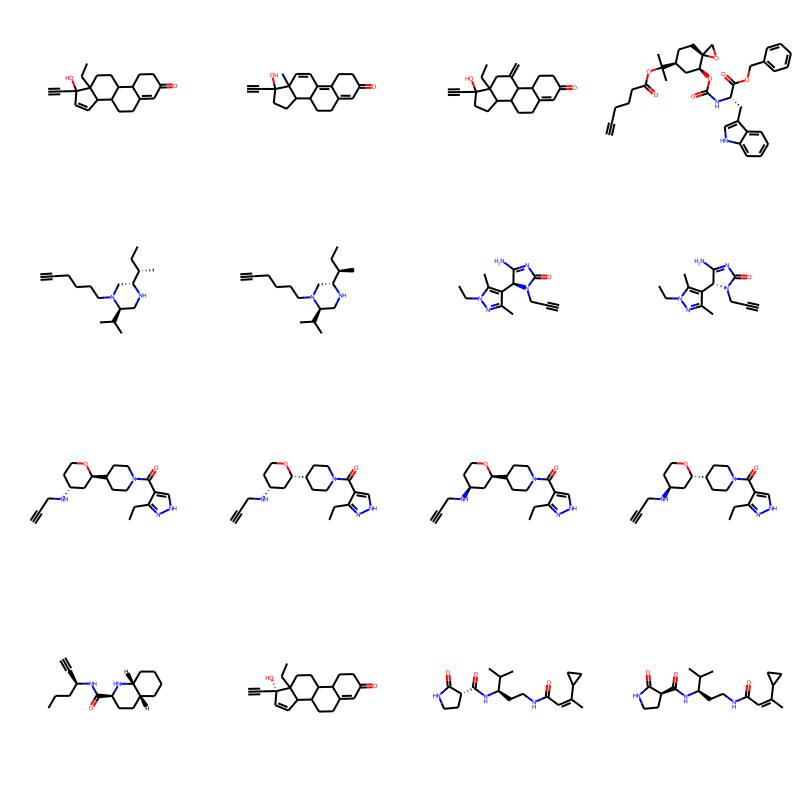

In [25]:
Draw.MolsToGridImage(df_4['mol'], molsPerRow=4, maxMols=16)

## Less bins

In [40]:
y_less = np.array(df_less.less_steps_bins)
x_less = np.array(df_less[['syba', 'sa', 'sc','MolWt']])
X_less = np.array(df_my[['syba', 'sascore', 'scscore','MolWt']])

In [41]:
RFR_less = RandomForestRegressor(random_state=0, max_depth=20, max_features='sqrt', n_estimators=200)

In [42]:
RFR_fit_less = RFR_less.fit(x_less, y_less)
predict_less = RFR_fit_less.predict(X_less)

<AxesSubplot:ylabel='Count'>

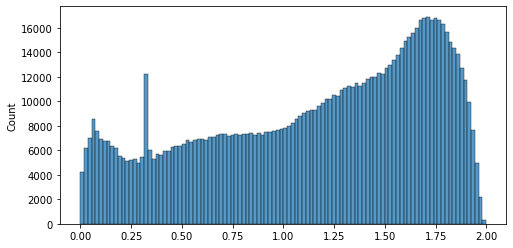

In [43]:
plt.figure(figsize=(8,4))
sns.histplot(predict_less)

In [45]:
df_my = df_my.assign(predict_less=[round(y) for y in predict_less])

In [46]:
df_my.predict_less.value_counts()
# 1,2 - 0 ; 3,4,5- 1 ; 6,7,8,9,10 - 2

1    473723
2    353270
0    169497
Name: predict_less, dtype: int64

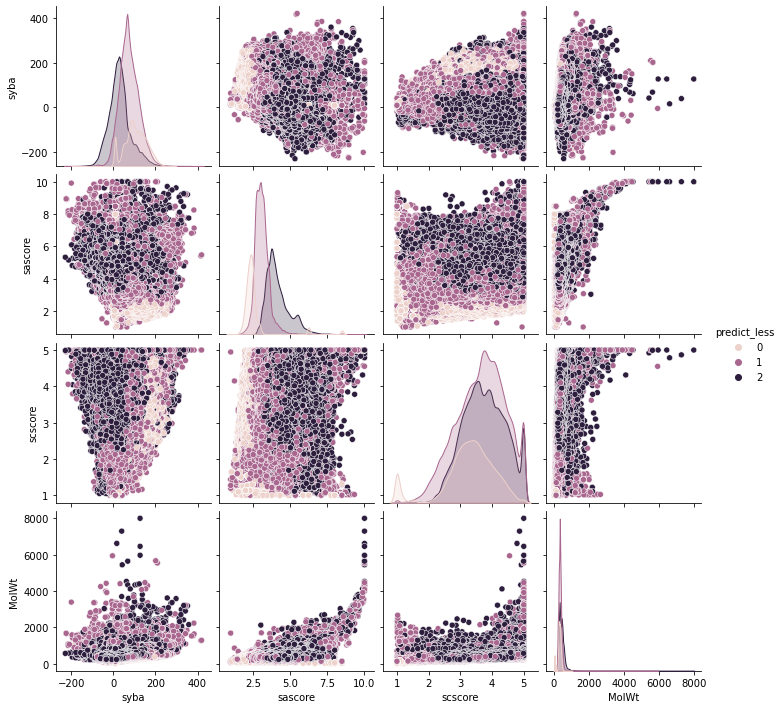

In [48]:
sns.pairplot(df_my[['predict_less','syba', 'sascore', 'scscore','MolWt']], hue='predict_less')

In [49]:
filepath = Path('data/7Mpredict_less.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_my.to_csv(filepath, index=False) 